In [1]:
%load_ext autoreload
%autoreload 2

from utility import format_plt, symmetric_stable_scaling_factor, plot_levy_normal_residuals, save_fig, plot_as_process_1d

format_plt()


In [2]:
from stonesoup.types.groundtruth import GroundTruthPath, GroundTruthState
from stonesoup.models.transition.driver import AlphaStableNSMDriver
from stonesoup.models.transition.driven import Langevin
from datetime import datetime, timedelta

In [3]:
from stonesoup.models.transition.base import CombinedLinearDrivenTransitionModel
import numpy as np


# And the clock starts
start_time = datetime.now().replace(microsecond=0)
seed = 40

mu_W = 0.
sigma_W2 = 1
alpha = 1.5
noise_case=2
c=10
theta=0.15

as_driver1 = AlphaStableNSMDriver(mu_W=mu_W, sigma_W2=sigma_W2, seed=seed, c=c, alpha=alpha, noise_case=noise_case)
# as_driver2 = AlphaStableNSMDriver(mu_W=mu_W, sigma_W2=sigma_W2, seed=seed+1, c=10, alpha=0.8)
as_driver2 = as_driver1
langevin_x = Langevin(cg_driver=as_driver1, theta=theta,)
langevin_y = Langevin(cg_driver=as_driver2, theta=theta,)
transition_model = CombinedLinearDrivenTransitionModel([langevin_x, langevin_y])


timesteps = [start_time]
truth = GroundTruthPath([GroundTruthState([0, 1, 0, 1], timestamp=timesteps[0])])

num_steps = 100
for k in range(1, num_steps + 1):
    timesteps.append(start_time+timedelta(seconds=k))  # add next timestep to list of timesteps
    truth.append(GroundTruthState(
        transition_model.function(truth[k-1], noise=True, time_interval=timedelta(seconds=1)),
        timestamp=timesteps[k]))


In [4]:
transition_model.mu_W

array([[0., 0.]])

In [5]:
transition_model.sigma_W2

array([[1, 0],
       [0, 1]])

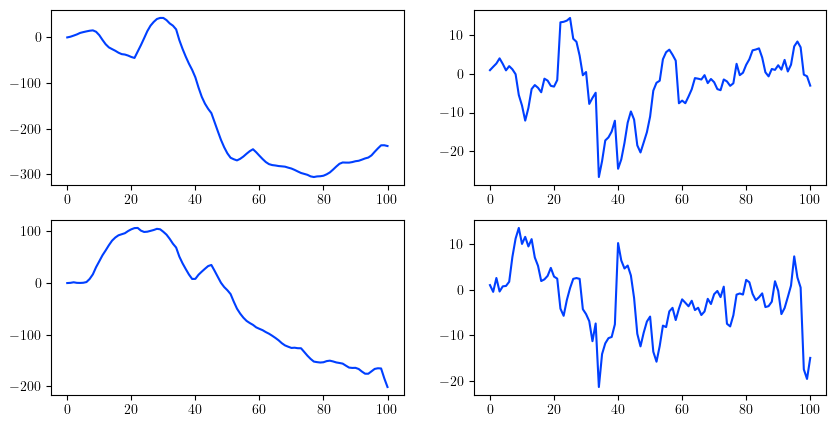

In [6]:
import matplotlib.pyplot as plt

t = np.array([(data.timestamp - start_time).total_seconds() for data in truth])
t -= t[0]

y0 = np.array([data.state_vector[0] for data in truth])
y1 = np.array([data.state_vector[1] for data in truth])
y2 = np.array([data.state_vector[2] for data in truth])
y3 = np.array([data.state_vector[3] for data in truth])

fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(10, 5))

axs[0][0].plot(t, y0)
axs[0][1].plot(t, y1)
axs[1][0].plot(t, y2)
axs[1][1].plot(t, y3)


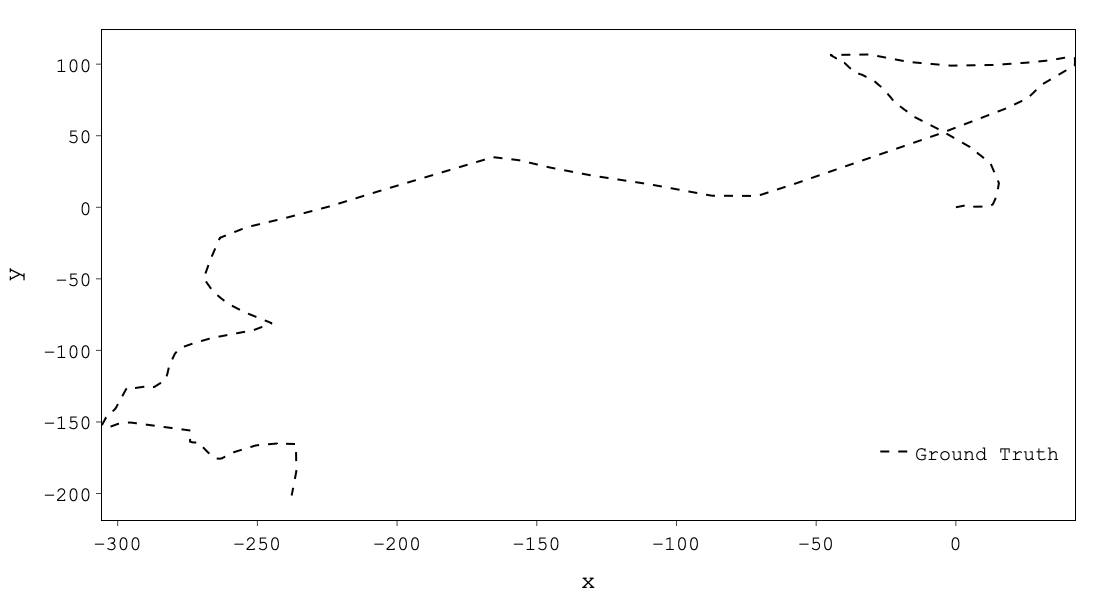

In [15]:
from stonesoup.plotter import Plotterly
import plotly.graph_objects as go

plotter_static = Plotterly(autosize=False,
    width=600,
    height=600,)
plotter_static.plot_ground_truths(truth, [0, 2], marker = {'color' : 'black'})
fig = plotter_static.fig
fig.write_image(f"./assets/as_langevin_mpf_performance_1.pdf")
fig.update_layout(
    margin = {'l':30,'t':30,'b':30, 'r': 30},
    # showlegend=False,
    plot_bgcolor='white',
    # font_family="Serif", 
    # font_color='black',
    font=dict(
        family="Courier New, monospace",
        size=20,  # Set the font size here
        color="black"
    ),
      # font_size=12,
    legend=dict(
        yanchor="bottom",
        y=0.1,
        xanchor="right",
        x=0.99
    ),
)
fig.update_xaxes(
    mirror=True,
    ticks='outside',
    showline=True,
    linecolor='black',
    # gridcolor='lightgrey'
)
fig.update_yaxes(
    mirror=True,
    ticks='outside',
    showline=True,
    linecolor='black',
    # gridcolor='lightgrey'
)
fig.write_image(f"./assets/as_langevin_mpf_performance_1.pdf")
fig
fig.write_image(f"./assets/as_langevin_mpf_performance_1.pdf")
fig

In [8]:
from stonesoup.types.detection import Detection
from stonesoup.models.measurement.linear import LinearGaussian

measurement_model = LinearGaussian(
    ndim_state=4,  # Number of state dimensions (position and velocity in 2D)
    mapping=(0, 2),  # Mapping measurement vector index to state index
    noise_covar=np.array([[25, 0],  # Covariance matrix for Gaussian PDF
                          [0, 25]])
    )

measurements = []
for state in truth:
    measurement = measurement_model.function(state, noise=True)
    measurements.append(Detection(measurement,
                                  timestamp=state.timestamp,                                  measurement_model=measurement_model))

In [16]:
from stonesoup.plotter import Plotterly

fig.write_image(f"./assets/as_langevin_mpf_performance_2.pdf")
plotter_static.plot_measurements(measurements, [0, 2], marker = {'color' : 'black'})
fig.write_image(f"./assets/as_langevin_mpf_performance_2.pdf")
fig
fig.write_image(f"./assets/as_langevin_mpf_performance_2.pdf")

In [10]:
from stonesoup.predictor.particle import MarginalisedParticlePredictor
from stonesoup.resampler.particle import SystematicResampler
from stonesoup.updater.particle import MarginalisedParticleUpdater

predictor = MarginalisedParticlePredictor(transition_model=transition_model)
resampler = SystematicResampler()
updater = MarginalisedParticleUpdater(measurement_model, resampler)

from scipy.stats import multivariate_normal
from stonesoup.types.numeric import Probability  # Similar to a float type
from stonesoup.types.state import MarginalisedParticleState
from stonesoup.types.array import StateVectors

number_particles = 1000

# Sample from the prior Gaussian distribution
states = multivariate_normal.rvs(np.array([0, 1, 0, 1]),
                                  np.diag([1., 1., 1., 1.]),
                                  size=number_particles)
covars = np.stack([np.eye(4) * 100 for i in range(number_particles)], axis=2) # (M, M, N)

# Create prior particle state.
prior = MarginalisedParticleState(
    state_vector=StateVectors(states.T),
    covariance=covars,
    weight=np.array([Probability(1/number_particles)]*number_particles),
                      timestamp=start_time-timedelta(seconds=1))

from stonesoup.types.hypothesis import SingleHypothesis
from stonesoup.types.track import Track

track = Track()

In [11]:
for measurement in measurements:
    prediction = predictor.predict(prior, timestamp=measurement.timestamp)
    # print(prediction.covariance[..., 0])
    hypothesis = SingleHypothesis(prediction, measurement)
    post = updater.update(hypothesis)
    # print(post.covariance)
    # print(type(post))
    # break
    track.append(post)
    prior = track[-1]   

In [12]:
plotter_static.plot_tracks(track, [0, 2], particle=False, uncertainty=True, marker = {'opacity' : 0.2, 'color': 'black'})
fig.write_image(f"./assets/as_langevin_mpf_performance_3.pdf")
fig
fig.write_image(f"./assets/as_langevin_mpf_performance_3.pdf")

In [13]:
from timeit import default_timer as timer


times = []
rmse = []
for number_particles in [1000, 500, 100, 50, 10, 2]:
    start = timer()
    # Sample from the prior Gaussian distribution
    states = multivariate_normal.rvs(np.array([0, 1, 0, 1]),
                                      np.diag([1., 1., 1., 1.]),
                                      size=number_particles)
    covars = np.stack([np.eye(4) * 100 for i in range(number_particles)], axis=2) # (M, M, N)
    
    # Create prior particle state.
    prior = MarginalisedParticleState(
        state_vector=StateVectors(states.T),
        covariance=covars,
        weight=np.array([Probability(1/number_particles)]*number_particles),
                          timestamp=start_time-timedelta(seconds=1))
    
    track = Track()
    for measurement in measurements:
        prediction = predictor.predict(prior, timestamp=measurement.timestamp)
        # print(prediction.covariance[..., 0])
        hypothesis = SingleHypothesis(prediction, measurement)
        post = updater.update(hypothesis)
        # print(post.covariance)
        # print(type(post))
        # break
        track.append(post)
        prior = track[-1]

    end = timer()
    times.append((end - start))

    predicted = np.array([t.mean[[0, 2],:] for t in track])
    target = np.array([t.state_vector[[0, 2], :] for t in truth])
    # np.linalg.norm()
    tmp = (target-predicted) ** 2
    # print(tmp.sum().shape)
    # print(np.sqrt(tmp.sum()).shape)
    rmse.append(np.sqrt(tmp.sum()) / len(truth))

print([f"{t:.4f}" for t in times]) # in seconds
print([f"{r:.4f}" for r in rmse])

['1.0114', '0.5469', '0.1504', '0.1000', '0.0604', '0.0516']
['0.5615', '0.5628', '0.5678', '0.5674', '0.5615', '0.6216']


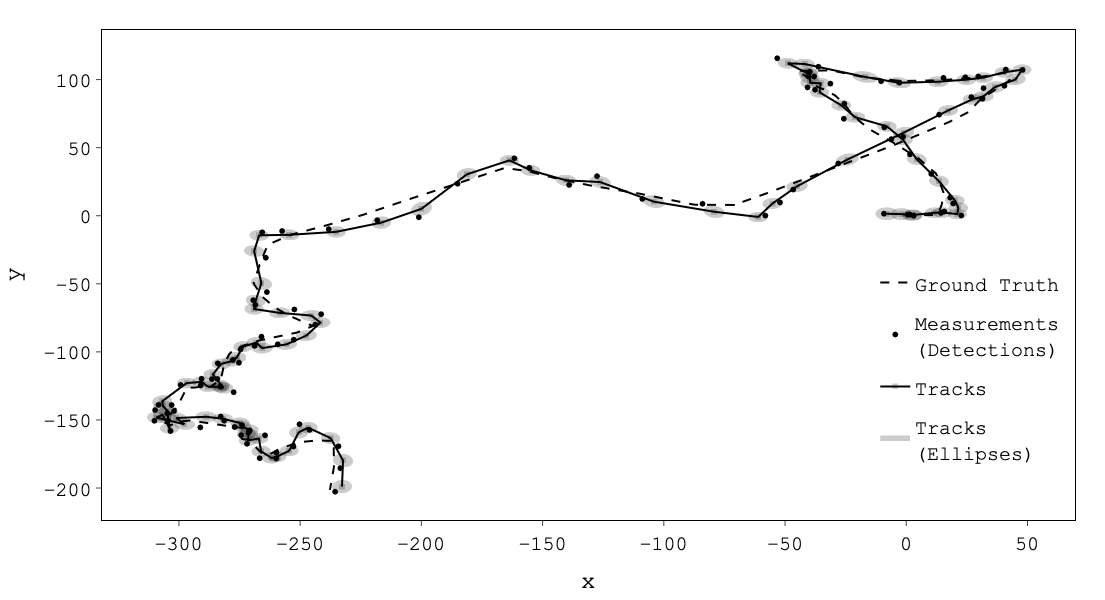

In [14]:
fig